<a href="https://colab.research.google.com/github/GermanM3/GermanM3/blob/master/Days_to_Cover(Stock_Sector).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pykrx finance-datareader

In [92]:
from pykrx import stock
import FinanceDataReader as fdr
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor, as_completed
from multiprocessing import Pool, cpu_count
import pandas as pd
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)


In [28]:
# @title K200 구성 지수 조회
#unique_names = indicies['Name'].unique()

# 각 고유한 이름과 그에 해당하는 코드를 딕셔너리로 저장
#name_code_map = {}
#for name in unique_names:
    # 해당 이름을 가진 행들을 필터링
    #code = indicies[indicies['Name'] == name]['Code'].iloc[0] # 첫 번째 값만 가져옴 (중복 방지)
    #name_code_map[name] = code

#print(name_code_map)


In [66]:
def fetch_sector_data(code, sector_map):
    try:
        sector_name = sector_map.get(code)
        if not sector_name:
            return None
        data = fdr.SnapDataReader(f'KRX/INDEX/STOCK/{code}')
        data['IDX_ID'] = sector_name
        return data
    except Exception as e:
        print(f"오류: 코드 '{code}' - {e}")
        return None

def get_sector_stocks_with_id(sector_codes):
    sector_map = {
        '1150': 'K 200 Communication',
        '1151': 'K 200 Construction',
        '1152': 'K 200 Heavy Industry',
        '1153': 'K 200 Steel/Material',
        '1154': 'K 200 Energy/Chemical',
        '1155': 'K 200 IT',
        '1156': 'K 200 Finance',
        '1157': 'K 200 Consumer Staples',
        '1158': 'K 200 Consumer Discretionary',
        '1159': 'K 200 Industrial Material',
        '1160': 'K 200 Health Care',
    }

    all_stocks = []

    print("섹터별 종목 데이터 병렬 조회 중...")

    with ThreadPoolExecutor(max_workers=8) as executor:  # CPU/IO 혼합 -> 8스레드 추천
        futures = {executor.submit(fetch_sector_data, code, sector_map): code for code in sector_codes}

        for future in as_completed(futures):
            result = future.result()
            if result is not None:
                all_stocks.append(result)

    if all_stocks:
        return pd.concat(all_stocks)
    else:
        print("조회된 데이터가 없습니다.")
        return pd.DataFrame()

my_sector_codes = ['1150','1151','1152','1153','1154','1155','1156','1157','1158','1159','1160']

# 함수 실행
combined_stocks_df = get_sector_stocks_with_id(my_sector_codes)

섹터별 종목 데이터 병렬 조회 중...


In [67]:
combined_stocks_df

,Code,Name,Close,RateCode,STR_CMP_PRC,Rate,Marcap,IDX_ID
0,005490,POSCO홀딩스,304500,2,-1500,-0.49,24644083884000,코스피 200 철강/소재
1,010130,고려아연,798000,2,-19000,-2.33,15978571854000,코스피 200 철강/소재
2,004020,현대제철,32550,1,100,0.31,4343660301750,코스피 200 철강/소재
3,103140,풍산,120950,2,-550,-0.45,3389536424100,코스피 200 철강/소재
4,001430,세아베스틸지주,27800,1,50,0.18,996966908200,코스피 200 철강/소재
...,...,...,...,...,...,...,...,...
23,114090,GKL,16880,1,460,2.80,1044123709600,코스피 200 경기소비재
24,009240,한샘,42700,1,500,1.18,1004898725600,코스피 200 경기소비재
25,004490,세방전지,63400,1,300,0.48,887600000000,코스피 200 경기소비재
26,039130,하나투어,53300,1,400,0.76,825613375600,코스피 200 경기소비재


In [94]:
# KOSPI200 종목 리스트
tickers = combined_stocks_df['Code'].astype(str).str.zfill(6).unique().tolist()

# 최근 10영업일 설정
end_date = datetime.today().strftime("%Y%m%d")
start_date = (datetime.today() - timedelta(days=20)).strftime("%Y%m%d")

# ---- 병렬 처리용 함수 ----
def get_avg_volume(ticker):
    try:
        df = stock.get_market_ohlcv_by_date(start_date, end_date, ticker)
        if df.empty:
            return (ticker, None)
        df = df.tail(10)
        return (ticker, df['거래량'].mean())
    except:
        return (ticker, None)

def get_latest_short_balance(ticker):
    try:
        df = stock.get_shorting_balance_by_date(start_date, end_date, ticker)
        if df.empty:
            return (ticker, None)
        return (ticker, df['공매도잔고'].iloc[-1])
    except:
        return (ticker, None)

# ---- 병렬 처리 실행 ----
with Pool(cpu_count()) as pool:
    avg_vol_list = pool.map(get_avg_volume, tickers)
    short_list = pool.map(get_latest_short_balance, tickers)

avg_vol_dict = dict(avg_vol_list)
short_latest = dict(short_list)

# ---- Days to Cover 계산 ----
results = []
for ticker in tickers:
    avg_vol = avg_vol_dict.get(ticker)
    short_qty = short_latest.get(ticker)
    if avg_vol and short_qty and avg_vol > 0:
        days_to_cover = short_qty / avg_vol
        results.append({
            "Ticker": ticker,
            "공매도잔고수량": short_qty,
            "10일평균거래량": avg_vol,
            "DaysToCover": days_to_cover
        })

# 결과 DataFrame
dtc_df = pd.DataFrame(results)
print(f"완성된 데이터 개수: {len(dtc_df)}")
print(dtc_df.sort_values("DaysToCover", ascending=False).head(10))

완성된 데이터 개수: 191
     Ticker  공매도잔고수량  10일평균거래량  DaysToCover
168  180640   911133   55032.9    16.556151
175  008770  1704974  110311.4    15.456009
145  373220  2534603  164098.6    15.445610
83   051900   644239   45580.7    14.134030
132  068270  4079224  292193.6    13.960689
103  096770  2535490  196096.8    12.929788
52   323410  7954478  651266.2    12.213866
74   042700  5833427  487993.2    11.953910
93   282330   293333   24707.5    11.872225
89   026960   664010   60614.3    10.954676


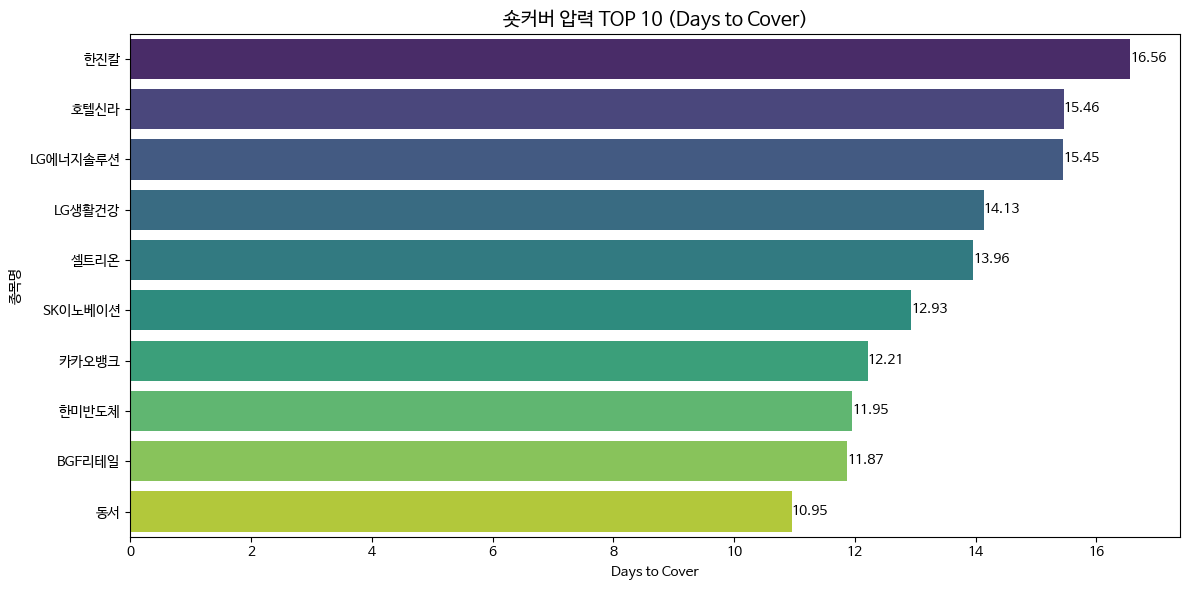

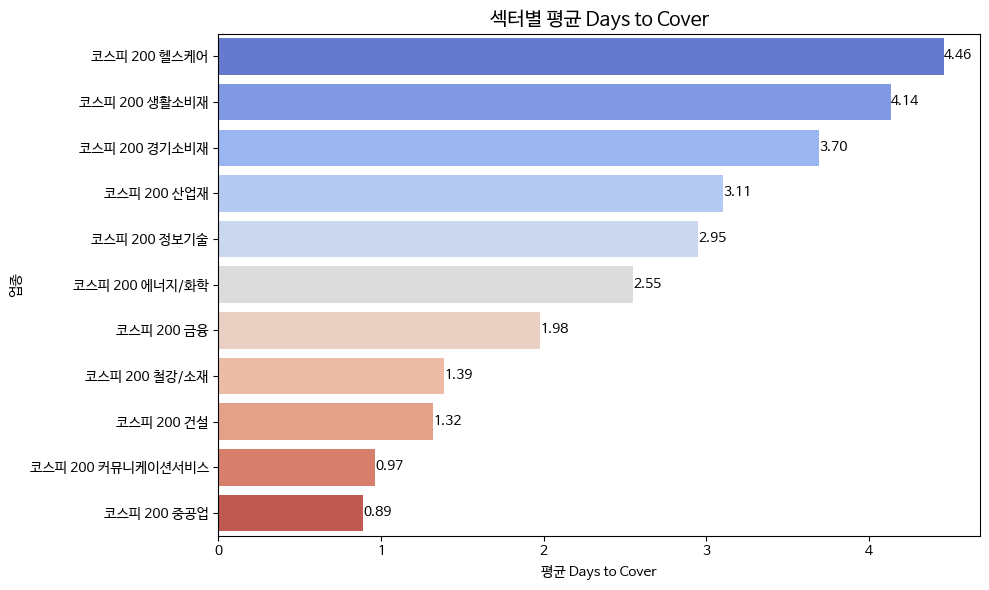

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. combined_stocks_df와 dtc_df 병합
combined_stocks_df['Code'] = combined_stocks_df['Code'].astype(str).str.zfill(6)
merged_df = dtc_df.merge(combined_stocks_df[['Code', 'Name', 'IDX_ID']], left_on='Ticker', right_on='Code', how='left')

# 2. Days to Cover 상위 10개 종목
top10 = merged_df.sort_values('DaysToCover', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=top10, x='DaysToCover', y='Name', hue='Name', dodge=False, palette='viridis', legend=False)
plt.title('숏커버 압력 TOP 10 (Days to Cover)', fontsize=14)
plt.xlabel('Days to Cover')
plt.ylabel('종목명')
for i, v in enumerate(top10['DaysToCover']):
    plt.text(v, i, f"{v:.2f}", va='center')
plt.tight_layout()
plt.show()

# 4. 섹터별 평균 Days to Cover
sector_avg = merged_df.groupby('IDX_ID')['DaysToCover'].mean().sort_values(ascending=False)

# 5. 시각화 - 섹터별 평균
plt.figure(figsize=(10, 6))
sns.barplot(
    x=sector_avg.values,
    y=sector_avg.index,
    hue=sector_avg.index,   # 경고 제거용
    dodge=False,
    palette='coolwarm',
    legend=False
)
plt.title('섹터별 평균 Days to Cover', fontsize=14)
plt.xlabel('평균 Days to Cover')
plt.ylabel('업종')
for i, v in enumerate(sector_avg.values):
    plt.text(v, i, f"{v:.2f}", va='center')
plt.tight_layout()
plt.show()